# Um breve tour do Fatiando a Terra

In [162]:
import fatiando

In [163]:
print(fatiando.__version__)

3c4953c170e1e9d964325ccd133a5ef28e319e89


## Criando formas geométricas

In [164]:
from fatiando import mesher

In [165]:
prisma = mesher.Prism(1, 5, 9, 29, 0, 3)

In [4]:
prisma

In [5]:
prisma.get_bounds()

[1.0, 5.0, 9.0, 29.0, 0.0, 3.0]

In [6]:
prisma.addprop('density', 250)

In [7]:
prisma.props

{'density': 250}

In [166]:
from fatiando.vis import myv

In [9]:
myv.figure()
myv.prisms([prisma])
myv.show()

In [14]:
myv.figure()
myv.prisms([prisma], 'density')
bounds = [0, 20, 0, 30, 0, 20]
myv.outline(bounds)
myv.wall_north(bounds)
myv.show()

## Desafio: Crie e visualize um modelo de 5 prismas

In [10]:
modelo = [prisma, mesher.Prism(10, 15, 2, 5, 5, 10, {'density': -250})]

In [14]:
myv.figure()
myv.prisms(modelo, 'density')
bounds = [0, 20, 0, 30, 0, 20]
myv.outline(bounds)
myv.wall_north(bounds)
myv.show()

## Modelagem direta

In [167]:
from fatiando import gridder

In [18]:
x, y = gridder.regular(bounds[:4], (50, 50))

In [20]:
x, y

(array([  0.,   0.,   0., ...,  20.,  20.,  20.]),
 array([  0.       ,   0.6122449,   1.2244898, ...,  28.7755102,
         29.3877551,  30.       ]))

In [168]:
import numpy as np

In [22]:
z = np.zeros_like(x)

In [23]:
z

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [169]:
from fatiando.gravmag import prism

In [25]:
grav = prism.gz(x, y, z, modelo)

In [26]:
grav

array([ -1.33961301e-04,  -1.20752358e-04,  -1.01987074e-04, ...,
         3.49127388e-05,   3.48324638e-05,   3.45110474e-05])

In [170]:
%matplotlib inline
import matplotlib.pyplot as plt

/home/leo/bin/anaconda/envs/iag/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


<matplotlib.tri.tricontour.TriContourSet instance at 0x7f4db98cc320>

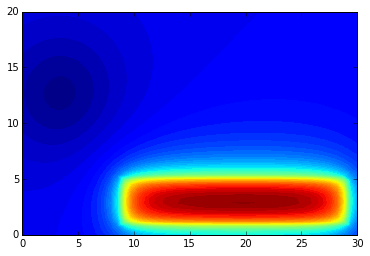

In [28]:
plt.tricontourf(y, x, grav, 60)

## Desafio: modelo de prismas da topografia

In [71]:
x, y, topo = np.loadtxt('topografia.txt', unpack=True)

In [72]:
dx = (x.max() - x.min())/(20 - 1)
dy = (y.max() - y.min())/(20 - 1)

In [73]:
dx, dy

(745.97000000000264, 982.8894736841811)

In [76]:
modelo = []
for i in xrange(len(x)):
    prisma = mesher.Prism(x[i] - dx/2, x[i] + dx/2,
                          y[i] - dy/2, y[i] + dy/2,
                          0, -topo[i], {'density': 2670})
    modelo.append(prisma)

In [95]:
myv.figure()
myv.prisms(modelo)
myv.show()

## Dados grav

In [138]:
lon, lat, y, x, alt, topo, grav = np.loadtxt('gravidade-havai.txt', unpack=True)

<matplotlib.tri.tricontour.TriContourSet instance at 0x7f4db639e4d0>

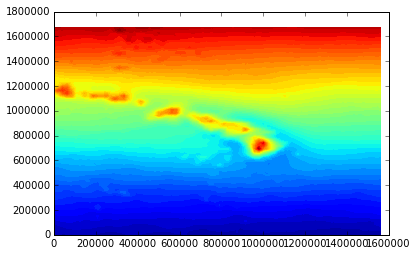

In [178]:
plt.tricontourf(y, x, grav, 60)

In [179]:
from fatiando.gravmag import normal_gravity

In [180]:
disturbio = grav - normal_gravity.gamma_closed_form(lat, alt)

<matplotlib.colorbar.Colorbar instance at 0x7f4db60e6560>

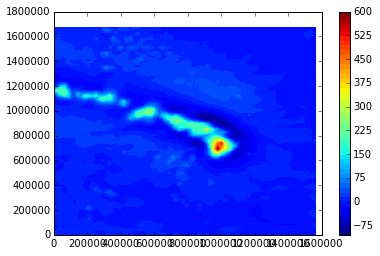

In [181]:
plt.tricontourf(y, x, disturbio, 60)
plt.colorbar()

In [182]:
bouguer = disturbio - normal_gravity.bouguer_plate(topo)

<matplotlib.colorbar.Colorbar instance at 0x7f4db5eafc68>

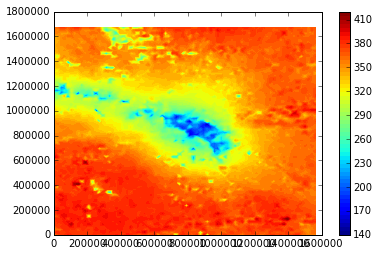

In [183]:
plt.tricontourf(y, x, bouguer, 60)
plt.colorbar()

## Desafio: calcule a correção topográfica

In [184]:
dx, dy = (x.max() - x.min())/100, (y.max() - y.min())/100


In [192]:
modelo = []
for i in xrange(len(x)):
    if topo[i] < 0:
        prisma = mesher.Prism(x[i] - dx/2, x[i] + dx/2,
                              y[i] - dy/2, y[i] + dy/2,
                              0, -topo[i])
        prisma.addprop('density', -1630)
    else:
        prisma = mesher.Prism(x[i] - dx/2, x[i] + dx/2,
                              y[i] - dy/2, y[i] + dy/2,
                              -topo[i], 0)
        prisma.addprop('density', 2670)
    modelo.append(prisma)    

In [198]:
def gera_modelo(x, y, topo, dx, dy):
    for i in xrange(len(x)):
        if topo[i] < 0:
            z1, z2, dens = 0, -topo[i], -1630
        else:
            z1, z2, dens = -topo[i], 0, 2670
        prisma = mesher.Prism(x[i] - dx/2, x[i] + dx/2,
                              y[i] - dy/2, y[i] + dy/2,
                              z1, z2, {'density':dens})
        yield prisma    

In [196]:
modelo = gera_modelo(x, y, topo, dx, dy)

In [195]:
myv.figure()
myv.prisms(modelo, 'density', scale=(1, 1, 50))
myv.show()

In [196]:
modelo = gera_modelo(x, y, topo, dx, dy)

In [197]:
%time grav_topo = prism.gz(x, y, -alt, modelo)

CPU times: user 40.5 s, sys: 32 ms, total: 40.5 s
Wall time: 40.5 s


In [199]:
bouguer2 = disturbio - grav_topo

<matplotlib.colorbar.Colorbar instance at 0x7f4db5bbfc20>

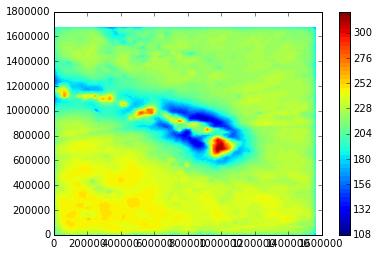

In [200]:
plt.tricontourf(y, x, bouguer2, 60)
plt.colorbar()